## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Additional Part - Considering timestamp](#timestamp)
- [Bibliography](#bibliography)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  In this test, the variant A is compared to the variant B in order to conclude which of the variants is more effective.

In this project, the goal is to understand the results of an A/B test run by an e-commerce website. Specifically, the goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability



In [2]:
# Importing main libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Reading the `ab_data.csv` data and storing it in `df`.

a. Reading the dataset and analyzing the top few rows:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Finding the number of rows in the dataset.

In [4]:
print('There are {} rows in the dataset.'.format(df.shape[0]))

There are 294478 rows in the dataset.


c. Finding the number of unique users in the dataset.

In [5]:
print('There are {} unique users in the dataset.'.format(df.user_id.nunique()))

There are 290584 unique users in the dataset.


d. Finding the proportion of users converted.

In [6]:
prop_converted = df[df['converted']==1].shape[0]/df.shape[0]
print('The proportion of converted users is {}.'.format(round(prop_converted,4)))

The proportion of converted users is 0.1197.


e. Finding the number of times the `new_page` and `treatment` don't match.

In [7]:
group_mismatch = df.query('landing_page=="new_page" and group != "treatment"').shape[0] + df.query('landing_page!="new_page" and group == "treatment"').shape[0]
print('The number of times the new_page and treatment don\'t match is {}.'.format(group_mismatch))

The number of times the new_page and treatment don't match is 3893.


f. Detect if any of the rows have missing values.

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Creating a new datafram **df2** removing rows in which treatment and control do not match with new_page and old_page respectively. 

In [9]:
df2 = df.loc[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))].copy()
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Getting some information about the dataframe.

a. How many unique **user_id**s are in **df2**?

In [11]:
print('There are {} unique users in df2.'.format(df.user_id.nunique()))

There are 290584 unique users in df2.


b. Is there any repeated user in **user_id**?

In [12]:
repeated_ids = df2.user_id.duplicated()
df2[repeated_ids].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[repeated_ids]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removing **one** of the rows with a duplicate **user_id**.

In [14]:
df2.drop(df2[repeated_ids].index[0], inplace = True)
df2.shape

(290584, 5)

`4.` Using **df2** to understand the data provided.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
print('The probability of an individual converting regardless of the page they receive is {}.'.format(round(df2[df2['converted']==1].shape[0]/df2.shape[0],4)))

The probability of an individual converting regardless of the page they receive is 0.1196.


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:

print('Given that an individual was in the control group, the probability they converted is {}.'.format(round(df2[(df2['group'] == 'control') & (df2['converted'] == 1)].shape[0]/ df2[df2['group'] == 'control'].shape[0] ,4)))

Given that an individual was in the control group, the probability they converted is 0.1204.


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
print('Given that an individual was in the treatment group, the probability they converted is {}.'.format(round(df2[(df2['group'] == 'treatment') & (df2['converted']==1)].shape[0]/df2[df2['group'] == 'treatment'].shape[0],4)))

Given that an individual was in the treatment group, the probability they converted is 0.1188.


d. What is the probability that an individual received the new page?

In [18]:
print('The probability that an individual received the new page is {}.'.format(round(df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0],4)))

The probability that an individual received the new page is 0.5001.


e. Considering the results from parts (a) through (d) above, a brief explanation of whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is no sufficient evidence to conclude that the new treatment page leads to more conversion.**

With the previous results, it is possible to observe that around 50% of individual received the new page. Considering the probability of conversion regardless of the page received, it is obtained a value of around 11.96%, therefore, in order to have evidence that the new page lead to more conversions, we wold expect that the conversion rate for those that received the new page is higher. However, the old and new page have a conversion rate with similar numbers, with values of respectively around 12,04% and 11,88%. Those values do not give evidence that the new treatment page performs better, but that it is more likelly that the old and new page have similar conversion rates.

<a id='ab_test'></a>
### Part II - A/B Test

Due to the time stamp associated with each event, it is technically possible to run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, a decision is made just based on all the data provided.  Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  

In case it is assumed that the old page is better unless the new page proves to be a better solution with a Type I error rate of 5%, the null and alternative hypothesis would respectively be:
  
$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$

`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Considering a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

It is performed the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
conversion_rate = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
print('The conversion rate for 𝑝𝑛𝑒𝑤 under the null is {}.'.format(round(conversion_rate,2)))

The conversion rate for 𝑝𝑛𝑒𝑤 under the null is 0.12.


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
df2[df2['converted'] == 1].shape[0]/df2.shape[0]
print('The conversion rate for 𝑝𝑜𝑙𝑑 under the null is {}.'.format(round(conversion_rate,2)))

The conversion rate for 𝑝𝑜𝑙𝑑 under the null is 0.12.


c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2[df2['group']=='treatment'].shape[0]
print('The number of individuals in the treatment group is {}.'.format(n_new))

The number of individuals in the treatment group is 145310.


d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df2['group']=='control'].shape[0]
print('The number of individuals in the control group is {}.'.format(n_old))

The number of individuals in the control group is 145274.


e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, conversion_rate, n_new)

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, conversion_rate, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
conversion_new = new_page_converted.sum()/new_page_converted.shape[0]
conversion_old = old_page_converted.sum()/old_page_converted.shape[0]
obs_diff = conversion_new-conversion_old
print('The difference between conversion rates is {}.'.format(round(obs_diff,6)))

The difference between conversion rates is -0.000422.


h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above. Storing all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, conversion_rate, n_new)
    old_page_converted = np.random.binomial(1, conversion_rate, n_old)
    conversion_new = (new_page_converted == 1).mean()
    conversion_old = (old_page_converted == 1).mean()
    p_diffs.append(conversion_new-conversion_old)

In [27]:
p_diffs = np.array(p_diffs)

i. Plotting a histogram of the **p_diffs**. 

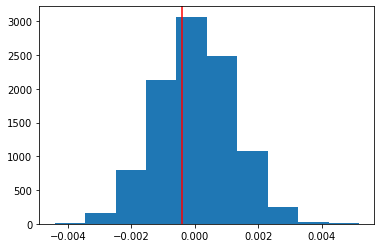

In [28]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color = 'red')
plt.show();

As expected, the plot looks like a normal distribution. The mean value of the sampling distribution is zero, being slightly different from the observed difference in conversion rates.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
print('The proportion of the p_diffs are greater than the actual difference observed in ab_data.csv is {}.'.format(round((p_diffs > obs_diff).mean(),6)))

The proportion of the p_diffs are greater than the actual difference observed in ab_data.csv is 0.639.


k. Explaining what was just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value that was calculated is the p-value. The p-value indicates the level of resemblance between the sample and population data, for example, a large p-value gives an indication that the sample score is similar to the population score. (A more common description of the p-value is the probability of observing the predicted result (or something more extreme in favor of the alternative hypothesis) given that the null hypothesis is true.)

The p-value is often analyzed in comparison with a significance level, in which this level generally assumes a value of 0.05 (however, it depends on the type of analysis). This significance level is chosen before the beginning of the test and gives a threshold for the p-value. If the obtained p-value is smaller than the significance level, there is a significant difference between sample and population characteristics, and there is evidence to reject the null hypothesis.

Considering the p-value obtained previously, we have evidence in favor of the null hypothesis and we fail to reject it. Therefore, it is provided evidence to conclude that there is no significant difference between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

Below cells compute the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2[(df2['converted']==1) & (df2['group'] == 'control')].shape[0]
convert_new = df2[(df2['converted']==1) & (df2['group'] == 'treatment')].shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

m. Using `stats.proportions_ztest` to compute your test statistic and p-value. 

In [31]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest([convert_new,convert_old], [n_new,n_old],alternative='larger')
print(stat)
print(pval)

-1.3109241984234394
0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score indicates how many standard deviations one element is from the mean. 

In the above case, the z-score indicates that the conversion rate for individuals that received the new page is 1.31 standard deviations lower than those individuals that received the old page.

Considering that the boundary for the rejection region with a 95% confidence interval is Z ≥ 1.96 or Z ≤ −1.96, we fail to reject the null hypothesis. Thus, we have evidence that the conversion rate is similar for both new and old pages.

The p-value indicates the probability of observing the test-statistic given the null hypothesis is true. This value also leads to the same conclusion as the z-score, as we fail to reject the null hypothesis.

The result from the z-test does agree with the one found in parts **j.** and **k.**. In both cases we fail to reject the null hypothesis and have evidence that the old page has a similar conversion rate as the new page.


<a id='regression'></a>

### Part III - A regression approach

`1.` In this final part, the aim is to observe that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Considering that each row is either a conversion or no conversion, the regression to be performed in this case is the **logistic regression**, because it allows to make predictions of categorical variables.

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.
First, it is needed to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  It is included an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Using **statsmodels** to instantiate your regression model on the two columns created in part b., then fitting the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [33]:
import statsmodels.api as sm
model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Providing the summary of the model.

In [34]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-04-15 09:37 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

The p-value associated with **ab_page** is 0.1899, this indicates that we fail to reject the null hypothesis, which in this case is that the independent variable has no significant effect on the target variable.

This value differs from the value found in in Part II because, as mentioned above, the p-value indicates if the independent variable is significant in predicting the dependent variable, whereas in Part II the p-value indicates the probability of observing the predicted result (or something more extreme in favor of the alternative hypothesis) given that the null hypothesis is true, being the null hypothesis that old and new pages result in a similar conversion rate.


f. Now, considering other things that might influence whether or not an individual converts.  Why it is a good idea to consider other factors to add into your regression model?  Are there any disadvantages to adding additional terms into your regression model?

Including new factors into the regression model is a good idea because there might exist other factors that can potentially influence the dependent variable, and including them would increase predictive capability. 

However, this inclusion of new factors must be carefully thought, because including variables that do not contribute in obtaining better results just increase the model complexity and could also decrease model performance, decreasing accuracy and increasing runtime and memory footprint. Moreover, using multiple independent variables could raise some issues, as it can happen that:
* a linear relationship does not exist between response and predictor
* there are correlated errors
* there is a non-constant variance between response and predictor
* there is the presence of outliers
* there is multicollinearity

g. Now along with testing if the conversion rate changes for different pages, also adding an effect based on which country a user lives in. 
The data for the countries is read in the **countries.csv** dataset and merged together your datasets on the appropriate rows.

Does it appear that country had an impact on conversion? 

In [35]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
df2 = df2.join(countries.set_index('user_id'), on = 'user_id')

In [37]:
df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [38]:
df2[['CA','UK','US']] = pd.get_dummies(df2.country)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [39]:
model2 = sm.Logit(df2['converted'], df2[['intercept','ab_page','CA','UK']])
result2 = model2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-04-15 09:37 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

Including the country as an independent variable in order to understand if the country has an impact on the conversion rate, it is possible to notice that **different countries do not have any impact on the conversion rate**.

This can be verified by the p-value, which is higher than the previously used significance level of 0.05 and indicates that the country variable is not statistically significant in predicting if the user will convert or not.

h. It was observed the individual factors of country and page on conversion. Now, it is regarded an interaction between page and country to see if there significant effects on conversion.  

In [40]:
df2_interaction = df2.copy()
df2_interaction['page_CA'] = df2_interaction['ab_page']*df2_interaction['CA']
df2_interaction['page_UK'] = df2_interaction['ab_page']*df2_interaction['UK']
df2_interaction.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,page_CA,page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [41]:
model3 = sm.Logit(df2_interaction['converted'], df2_interaction[['intercept','ab_page','CA','UK','page_CA','page_UK']])
result3 = model3.fit()
result3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-04-15 09:37 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
page_CA      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
page_UK       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

Considering a Logistic Regression Model including the interaction between country and page variables indicated **no significant effect on the conversion rate**.
Such conclusion can be supported by the p-values which indicate that none of the variables are statistically significant in predicting if the user will convert or not.

<a id='timestamp'></a>

### Addtional part - Considering timestamp
In this additional part, it is included the timestamp in the Regression Model in order to understand if the day of the week or weekday/weekend has any influence in the conversion rate.

In [50]:
# Convert timestamp to datetime format
df2['timestamp']=pd.to_datetime(df2['timestamp'])

In [54]:
# Get day of week
df2['dow'] = df2['timestamp'].dt.dayofweek
df2[['mon','tue','wed','thur','fri','sat','sun']] = pd.get_dummies(df2['dow'])

In [58]:
# Define if it is weekday or weekend
df2['weekday'] = df2.loc[:,'mon':'sat'].sum(axis=1)
df2['weekend'] = df2.iloc[:,-2:-1].sum(axis=1)

In [61]:
# Using the Logistic Regression to undersand if any specifc day of week has influence on conversion
# the baseline day is Sunday
model4 = sm.Logit(df2['converted'],df2[['intercept','ab_page','mon','tue','wed','thur','fri','sat']])
result4 = model4.fit()
result4.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212786.8299
Date:               2020-04-15 10:00 BIC:              212871.4671
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           7                LL-Null:          -1.0639e+05
Df Residuals:       290576           LLR p-value:      0.40444    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9995    0.0165  -121.2225  0.0000  -2.0318  -1.9672
ab_page      -0.0149    0.0114    -1.3058  0.1916  -0.0373   0.0075
mon           0.0253    0.0211     1.1986  0.2307  -0.0161   0.0667
tue           0.0101    0.0210     0.4821  0.6297  -0.0310   0.0513
wed           0.0177    0.0219     0.8085  0.4188  -0.0252   0.0606
thur          0.0142    0.0219     0.6465  0.5180  -0.0288   0.0572
fri          -0.0172    0.0220    -0.7790  0.4360  -0.0603   0.0260
sat           0.0223    0.0218     1.0200  0.3077  -0.0205   0.0651
==================================================================

"""

Regarding the obtained p-values for each independent variable, it is possible to notice that they favor the null hypothesis and we fail to reject it, indicating that the independent variable has no significant effect on the target variable.

In [62]:
# Using the Logistic Regression to undersand if weekday or weekend has influence on conversion
# the baseline is weekend
model5 = sm.Logit(df2['converted'],df2[['intercept','ab_page','weekday']])
result5 = model5.fit()
result5.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.7957
Date:               2020-04-15 10:05 BIC:              212813.5347
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.32094    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9995    0.0165  -121.2211  0.0000  -2.0318  -1.9671
ab_page      -0.0150    0.0114    -1.3115  0.1897  -0.0374   0.0074
weekday       0.0124    0.0167     0.7438  0.4570  -0.0203   0.0451
==================================================================

"""

Regarding the obtained p-values for the weekday independent variable, it has no significant effect on the target variable.

<a id='conclusions'></a>
## Conclusions
The aim of the present project was to identify if individuals being presented to a certain landing page would increase the conversion rate for an e-commerce website. The main outcome of the project is to identify if a new page should be implemented, keep the old page or run the experiment for a longer period.

In order to achieve such results, first, the data was organized and the DataFrame was updated. Next, some probabilities were computed in order to understand the values in the data frame and identify a possible issue for hypothesis testing. Finally, an A/B test was run in order to identify which page could lead to a higher conversion rate. This test was run considering an estimate from the null and calculating the z-score. In both cases, we fail to reject the null hypothesis and have evidence that the old page has a similar conversion rate as the new page.

Also, it was performed a regression approach, in which the data was fitted to the Logistic Regression Model. First, it was considered a model with information only about the landing page (if new or old). Afterward, it was included information about the country in which the user was accessing the website and considered the interaction between country and landing page. 
Considering this approach, we failed to reject the null hypothesis in both cases (the null hypothesis was that the independent variable had no significant effect on the target variable).

In addition to what was proposed in the project, the timestamp in which the user accessed the website was considered. Considering the different days of the week did not lead to any conclusion about days with higher conversion rate. Moreover, considering if weekday or weekend did not bring any further information about the user conversion.

In this project, it was considered a Logistic Regression Model as there was a need for the prediction of a categorical variable. This model results in an output of a probability between 0 and 1, differently from the linear regression, in which it can output any possible value. In both models including more independent variables can lead to a better fit of the data. However, the inclusion of independent variables must be carefully thought, as it increases model complexity and can result in overfitting, which reduces the capability that the model has to generalize beyond the data for which it was fitted.

As a final outcome, considering all the results obtained during this project, it is possible to conclude that **there is evidence that the old and new page leads to a similar conversion rate**. Moreover, there is no independent variable among the presented variables that are statistically significant in predicting the conversion rate if a Logistic Regression Model is used.


<a id='bibliography'></a>

## Bibliography

http://knowledgetack.com/python/statsmodels/proportions_ztest/

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html

https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html

http://www.personal.kent.edu/~jortiz/earthstats/topic06notes.html

https://medium.com/analytics-vidhya/everything-you-should-know-about-p-value-from-scratch-for-data-science-f3c0bfa3c4cc